## Сегментация изображений

Перед нами стоит задача **сегментации** кт-снимков легких и определения областей поражения от Covid-19. 

Исходные данные: **json** с названиями файлов,
**images** - сами данные, **labels** - разметка: 0 - этот пиксель **НЕ относится** к поврежденному лёгкому, 1 - пиксель **относится** к повреждённому лёгкому

Каждый скан - numpy arrays of shape (512, 512, n_slices)



## 0. Подготовка данных и импорт библиотек

In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-y5j6ep3x
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-y5j6ep3x
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 376 kB 10.0 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=98008 sha256=8ea887e225b19d4f0186b32cdb34af2ffb294636f3cb1b1ea92adff595c096ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-pei8b249/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d75a3264bb7417c1e

In [2]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import torchvision
import random

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import albumentations as A # Будем использовать для аугментации данных
import segmentation_models_pytorch as smp

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # Определяем доступность gpu

device = torch.device(device)
print(device)

cuda:0


In [4]:
# from google.colab import drive # Маунтим диск 
# drive.mount('/content/drive')

Структура проекта:
1. core_path - общий путь до проекта. В коллабе это "./drive/MyDrive/Deep Learning/CovidKaggleTask/"

2. path = core_path + "data/data/" - Путь до самих файлов. В этой директории есть сам json файл, папки images и labels, в которых есть информация о кт-сканах

3. core_path/models - путь до моделей для обучения. В силу больших по объёму данных, необходимо сохранять каждый раз модель. Таким образом в этой папке сохраняются модели после каждой эпохи. lungs_ct_model_1.h5 - корректное название для модели, которая была обучена только на одной эпохе

In [5]:
#Для Collab

#Создание подключения
from google.colab import drive
drive.mount('/content/drive')

#Расположение файлов
core_path = "./drive/MyDrive/Работа/DL Курс Тинькофф/kaggle covid detection/" # Определяем пути до файлов
path = core_path + "data/data/"

Mounted at /content/drive


In [6]:
# # Для каггла
# core_path = "../input/tgcovid/"
# path = core_path + "data/data/"

## 1. Работа с датасетом

In [7]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path + "images") if isfile(join(path + "images", f))]
onlyfiles[:5] # Получаем список всех файлов

['study_0255.nii',
 'study_0256.nii',
 'study_0257.nii',
 'study_0258.nii',
 'study_0260.nii']

Определяемся с аугментацией данных. Пытаемся понять, какие преобразования могут быть полезными для данной задачи:
- **Повороты на небольшое количество градусов** (поворот никак не меняет логику распределения классов)
- **Вертикальное отображение**
- **Горизонтальное отображение**
- **Перспектива** (несколько иной угол снятия кт увеличит набор исходных данных)
- **Блюр** (шум поможет не переобучаться модели)

Создаём класс датасета, в котором прописываем метод __init__(self, список из сканов для трейна, список из сканов для валидации, аугментации), метод длины датасета и получения элемента из датасета

In [8]:
class CovidDataset(Dataset):
    def __init__(self, X_data, without_covid_max=9999999):
        # Загружаем сканы кт
        path_images = os.path.join(path, 'images')
        path_labels = os.path.join(path, 'labels')
        
        # Подгружаем json с инфой по разметке
        with open(core_path + 'training_data.json', 'r') as f:
            dict_training = json.load(f)

        self.X = [] 
        self.Y = []
        without_covid = 0
        for entry in tqdm(dict_training):
            image = nib.load(os.path.join(path_images, entry['image'][:-3])) # Загружаем конкретный кт-скан по названию из json
            label = nib.load(os.path.join(path_labels, entry['label'][:-3])) # Загружаем лейблы/разметку для кт-скана
            image = torch.tensor(image.get_fdata(), dtype=torch.uint8).transpose(1, 2).transpose(0, 1) # Меняем размерность с [43, 512, 512]
            label = torch.tensor(label.get_fdata(), dtype=torch.uint8).transpose(1, 2).transpose(0, 1) # на [512, 512, 43] для всех картинок
            
            
            if entry['image'][:-3] in X_data: # Если этот кт-скан в трейне - загружаем его туда
                for i in range(len(image)): # Пробегаемся по всем слоям в нужном кт-скане image
                    if label[i].sum() != 0:
                        self.X.append(image[i]) # Добавляем отдельные картинки
                        self.Y.append(label[i])
                    else:
                        if without_covid >= without_covid_max:
                            continue
                        else:
                            without_covid += 1
                            self.X.append(image[i]) # Добавляем отдельные картинки
                            self.Y.append(label[i])
    
    
    def __len__(self):
        return len(self.X)
    
    
    def __getitem__(self, idx):
        # Делаем случайную аугментацию
        # Метод делает аугментацию как для image - нашего скана слоя, так и для его разметки
        # Для начала определяем поворот на угол...
        degrees = [-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
        X = self.X[idx]
        y = self.Y[idx]
        X = X.type(torch.float)
        y = y.type(torch.float)
        X = (torch.Tensor(np.array([X.numpy()]) / 255))
        y = (torch.Tensor(np.array([y.numpy()])))
        value = random.random()
        if random.random() > 0.5:
            value = random.random()
            if value > 0.5:
                X = torchvision.transforms.functional.vflip(X)
                y = torchvision.transforms.functional.vflip(y)
            else:
                X = torchvision.transforms.functional.hflip(X)
                y = torchvision.transforms.functional.hflip(y)
        value = random.random()
        if value >= 0.1:
            degree = random.choice(degrees)
            X = torchvision.transforms.functional.rotate(X, degree)
            y = torchvision.transforms.functional.rotate(y, degree)
        else:
            pass
        value = random.random()
        if value > 0.5:
            X = torchvision.transforms.RandomPerspective(distortion_scale=0.15, p=0.5, interpolation=2, fill=0)(X)
            y = torchvision.transforms.RandomPerspective(distortion_scale=0.15, p=0.5, interpolation=2, fill=0)(y)
        else:
            pass
        value = random.random()
        if value > 0.5:
            X = torchvision.transforms.GaussianBlur(1)(X)
            y = torchvision.transforms.GaussianBlur(1)(y)
        else:
            pass
        
        # Важно! Нельзя передать просто картинку (512, 512), так как используется свёртка по многим измерениям
        # Необходимо передать в формате [палитра, ширина, высота] - [1, 512, 512]
        return torch.Tensor(X), torch.Tensor(y) 
                                            

In [9]:
batch_size = 8

# Перемешаем названия файлов в случайном порядке (для генерации трэйна и валидации)
np.random.shuffle(onlyfiles) 
train_dataset = CovidDataset(onlyfiles[:33], 50)
valid_dataset = CovidDataset(onlyfiles[33:], 50)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
s = 1
for i in train_loader:
    print(len(train_loader))
    print(i[0].size())
    print(i[1].size())

    s += 1
    if s > 2:
        break
    

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:771: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


69
torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 512, 512])
69
torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 512, 512])


In [11]:
# # Download an example image
# import urllib
# url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)

## 2. Определяемся со структурой нейронной сети

В данном случае, была выбрана сеть Unet (https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

Она отлично подходит для анализа медицинских изображений, так как в ней есть множество skip-connection для решения проблемы затухания градиента (vanishing gradient), а также увеличения информации для следующих слоёв, которые отвечают за выбор признаков (т. е. decoder)

In [12]:
import torch.nn as nn

class Unet(nn.Module): # Определим структуру нейронной сети Unet
    def block_down(self, in_features, out_features):
        return nn.Sequential(*[nn.Conv2d(in_features, out_features, (3, 3), padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_features)])
    
    def block_up(self, in_features, out_features):
        return nn.Sequential(*[nn.Conv2d(in_features, out_features, (3, 3), padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_features)])
    
    
    def __init__(self):
        super(Unet, self).__init__()
        self.block_up11 = self.block_down(1, 32)
        self.block_up12 = self.block_down(32, 32)
        self.max_pooling11 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.block_up21 = self.block_down(32, 64)
        self.block_up22 = self.block_down(64, 64)
        self.max_pooling22 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.block_up31 = self.block_down(64, 128)
        self.block_up32 = self.block_down(128, 128)
        self.max_pooling33 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.block_up41 = self.block_down(128, 256)
        self.block_up42 = self.block_down(256, 256)
        self.max_pooling44 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.block_up51 = self.block_down(256, 512)
        self.block_up52 = self.block_down(512, 512)
        
        self.block_up61 = nn.Upsample(scale_factor=2)
        self.block_up62 = self.block_up(512, 256)
        self.block_up63 = self.block_up(512, 256)
        self.block_up64 = self.block_up(256, 256)
        
        self.block_up71 = nn.Upsample(scale_factor=2)
        self.block_up72 = self.block_up(256, 128)
        self.block_up73 = self.block_up(256, 128)
        self.block_up74 = self.block_up(128, 128)
        
        self.block_up81 = nn.Upsample(scale_factor=2)
        self.block_up82 = self.block_up(128, 64)
        self.block_up83 = self.block_up(128, 64)
        self.block_up84 = self.block_up(64, 64)
        
        self.block_up91 = nn.Upsample(scale_factor=2)
        self.block_up92 = self.block_up(64, 32)
        self.block_up93 = self.block_up(64, 32)
        self.block_up94 = self.block_up(32, 32)
        
        self.block_up100 = self.block_up(32, 1) 
        
    
    def forward(self, x):
        out = self.block_up11(x)
        out = self.block_up12(out)
        
        save1 = out.clone()
        
        out = self.max_pooling11(out)
        
        out = self.block_up21(out)
        out = self.block_up22(out)
        
        save2 = out.clone()
        
        out = self.max_pooling22(out)
        
        out = self.block_up31(out)
        out = self.block_up32(out)
        
        save3 = out.clone()
        
        out = self.max_pooling33(out)
        
        out = self.block_up41(out)
        out = self.block_up42(out)
        
        save4 = out.clone()
        
        out = self.max_pooling44(out)
        
        out = self.block_up51(out)
        out = self.block_up52(out)
        
        
        out = self.block_up61(out)
        out = self.block_up62(out)
        out = self.block_up63(torch.cat((out, save4), 1))
        out = self.block_up64(out)

        out = self.block_up71(out)
        out = self.block_up72(out)
        out = self.block_up73(torch.cat((out, save3), 1))
        out = self.block_up74(out)

        out = self.block_up81(out)
        out = self.block_up82(out)
        out = self.block_up83(torch.cat((out, save2), 1))
        out = self.block_up84(out)

        out = self.block_up91(out)
        out = self.block_up92(out)
        out = self.block_up93(torch.cat((out, save1), 1))
        out = self.block_up94(out)

        out = self.block_up100(out)
        out = nn.Sigmoid()(out)
        
        return out

Мы реализовали собственную модель **Unet**. Она довольна эффективна, однако в сложных задачах её может не хватать, поэтому к ней навешивают хорошую модель для классификации (например, ResNet).

Таким образом, сложная модель будет **Unet++**

Рассмотрим три лосса и выберем, который более **эффективный**:
- Dice Loss
- TverskyLoss
- Focal loss

In [13]:
import torch
import torch.nn.functional as F

def dice_loss(inputs: torch.Tensor, targets: torch.Tensor):
    inp = inputs.contiguous().view(-1)
    tar = targets.contiguous().view(-1)
    noise = random.randint(1, 1000) / 10000000000
    
    return 1 - ((2 * (inp * tar).sum() + noise) / ((inp).sum() + (tar).sum() + noise))

In [14]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets, smooth=1):
        y_pred = inputs
        y_true = targets
        y_true_pos = y_true.view(-1)
        y_pred_pos = y_pred.view(-1)
        true_pos = torch.sum(y_true_pos * y_pred_pos)
        false_neg = torch.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = torch.sum((1 - y_true_pos) * y_pred_pos)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + (1 - self.alpha) * false_pos + smooth)

In [15]:
def sigmoid_focal_loss(inputs, targets, alpha=0.25, gamma=2, reduction="none"):
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

Уже изрядно опробовав различные лоссы, лучшим решением на данный момент является **TverskyLoss**

Его и будем использовать для итогового обучения

### 3. Обучение модели

#### Подготовка модели

Сначала подгружаем модель **Unet++**, если у нас нет других **уже обученных** моделей

In [16]:
import segmentation_models_pytorch as smp

use_previous_versions = False
previous_i = 0
path_to_model = "output/kaggle/working/"

# Проверяем, вдруг мы можем подгрузить уже обученную модель
if use_previous_versions:
    models_variation = []
    for put, papki, files in os.walk("."):
        for el in files:
            if "lungs_ct_model" in el:
                models_variation.append(el)
                
    # Название файла - lungs_ct_model_1.h5
    if len(models_variation) != 0:
        models_variation = sorted(models_variation, key=lambda x: - int(x.split("_")[-1].split(".")[0]))
        model = torch.load(models_variation[-1])
        previous_i = int(models_variation[0].split("_")[-1].split(".")[0])
        print("Загружена прошлая модель: {}".format(str(previous_i)))
    else:
        model = smp.UnetPlusPlus(encoder_name='resnet18', in_channels=1, classes=1, activation="tanh")
        print("Загружен непредобученный Unet++")
else:
    model = smp.UnetPlusPlus(encoder_name='resnet18', in_channels=1, classes=1, activation="sigmoid")
    print("Загружен непредобученный Unet++")


device = torch.device('cuda:0')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Загружен непредобученный Unet++


#### Метрики

Определяемся с метриками:

Нам необходимо детектировать ковид, а значит, нам подойдёт полнота **recall** (если мы будем детектировать ковид, где только есть подозрения - будет хорошо)

Однако детектировать всё подряд не очень, а значит, нужно и смотреть на **precision**

Таким образом, **f-мера** прекрасно подойдёт

In [17]:
def recall(output_batch, correct_batch, threshold=0.99):    
    output_numpy = output_batch.detach().numpy()
    correct_numpy = correct_batch.detach().numpy()
    
    amount_of_correct = np.count_nonzero(np.where(output_numpy > threshold, output_numpy, 0) + correct_numpy == 2)
    amount_all = np.count_nonzero(correct_numpy == 1)
    try:
        return amount_of_correct / amount_all
    except:
        return np.nan

def precision(output_batch, correct_batch, threshold=0.99):   
    output_numpy = output_batch.detach().numpy()
    correct_numpy = correct_batch.detach().numpy()
    
    amount_of_correct = np.count_nonzero(np.where(output_numpy > threshold, output_numpy, 0) + correct_numpy == 2)
    amount_all = np.count_nonzero(output_numpy == 1)
    try:
        return amount_of_correct / amount_all
    except:
        return np.nan
    
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [18]:
num_epoch = 125
lr = 0.0005

dice_loss_criterion = dice_loss
focal_loss_criterion = sigmoid_focal_loss
tverskoy_loss = TverskyLoss(alpha=0.7)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)

In [19]:
losses = []

for epoch in tqdm(range(num_epoch)):
    epoch_losses = []
    
    # Обучаем модель
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        output = model(X)
        
        loss = tverskoy_loss(output, Y)
        loss.backward()
        clip_grad_norm_(model.parameters(), 99999)
        
        optimizer.step()

        del X
        del Y
        torch.cuda.empty_cache()
        epoch_losses.append(loss.item())
        
    # Добавляем лосс
    common_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(common_loss)
    
    # Считаем метрики на валидации:
    valid_precision = []
    valid_recall = []
    for X, Y in valid_loader:
        X = X.to(device)
        rec = recall(model(X).cpu(), Y)
        prec = precision(model(X).cpu(), Y)
        if prec is not np.nan:
            valid_precision.append(prec)
        if rec is not np.nan:
            valid_recall.append(rec)
        del X
        del Y
    
    # Выводим информацию
    print("--" * 15)
    print("Epoch: {}".format(str(epoch)))
    print("Loss:\t\t {:7.5f}".format(common_loss))
    print("Learning rate: {:9.8f}".format(float(optimizer.state_dict()["param_groups"][0]["lr"])))
    
    try:
        prec = sum(valid_precision) / len(valid_precision)
        print("Precision:\t {:7.3%}".format(prec))
    except:
        print("Precision:\t No info")
        
    try:
        rec = sum(valid_recall) / len(valid_recall)
        print("Recall:\t\t {:7.3%}".format(rec))
    except:
        print("Recall:\t\t No info")
        
    try:
        print("F1-score: \t {:7.3f}".format(f1_score(prec, rec)))
    except:
        print("F1-score: No info".format(f1_score(prec, rec)))
    
    # Сохраняем модель и делаем шаг scheduler
    torch.save(model, "lungs_ct_model_" + str(epoch + previous_i) + ".h5")
    scheduler.step()

  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:771: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


------------------------------
Epoch: 0
Loss:		 0.95137
Learning rate: 0.00050000
Precision:	 18.142%
Recall:		 29.954%
F1-score: 	   0.226
------------------------------
Epoch: 1
Loss:		 0.84718
Learning rate: 0.00049125
Precision:	 21.742%
Recall:		 23.089%
F1-score: 	   0.224
------------------------------
Epoch: 2
Loss:		 0.65872
Learning rate: 0.00048265
Precision:	 33.112%
Recall:		 31.949%
F1-score: 	   0.325
------------------------------
Epoch: 3
Loss:		 0.57591
Learning rate: 0.00047421
Precision:	 24.218%
Recall:		 36.511%
F1-score: 	   0.291
------------------------------
Epoch: 4
Loss:		 0.53518
Learning rate: 0.00046591
Precision:	 29.230%
Recall:		 45.216%
F1-score: 	   0.355
------------------------------
Epoch: 5
Loss:		 0.51850
Learning rate: 0.00045775
Precision:	 32.824%
Recall:		 46.175%
F1-score: 	   0.384
------------------------------
Epoch: 6
Loss:		 0.50801
Learning rate: 0.00044974
Precision:	 24.814%
Recall:		 50.176%
F1-score: 	   0.332
--------------------

Таким образом, мы обучили модель и она достигла приемлемого результата

In [20]:
from sklearn.metrics import roc_curve

y_real = []
y_pred = []
for X, Y in valid_loader:
    X = X.to(device)
    y_real += Y.view(Y.shape[0] * Y.shape[1] * Y.shape[2] * Y.shape[3]).int().cpu().detach().tolist()
    y_pred += model(X).view(Y.shape[0] * Y.shape[1] * Y.shape[2] * Y.shape[3]).cpu().detach().tolist()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:771: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


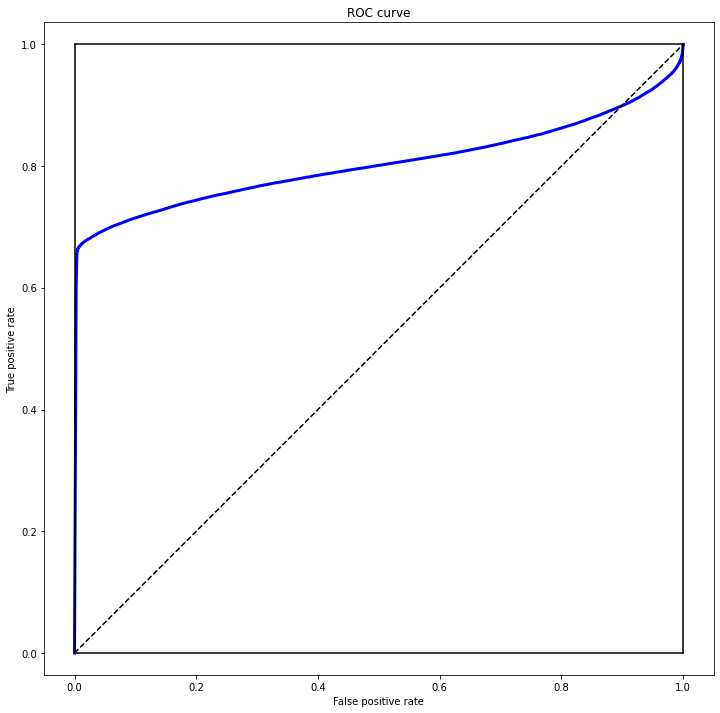

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
fpr, tpr, thresholds = roc_curve(np.array(y_real), np.array(y_pred))
plt.plot(fpr, tpr, 'b', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0], [0, 1], 'k')
plt.plot([1, 1], [0, 1], 'k')
plt.plot([0, 1], [0, 0], 'k')
plt.plot([0, 1], [1, 1], 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axis('equal')
plt.title('ROC curve')
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_real, y_pred)

0.8032322415124165

### 4. Визуализация

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:771: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


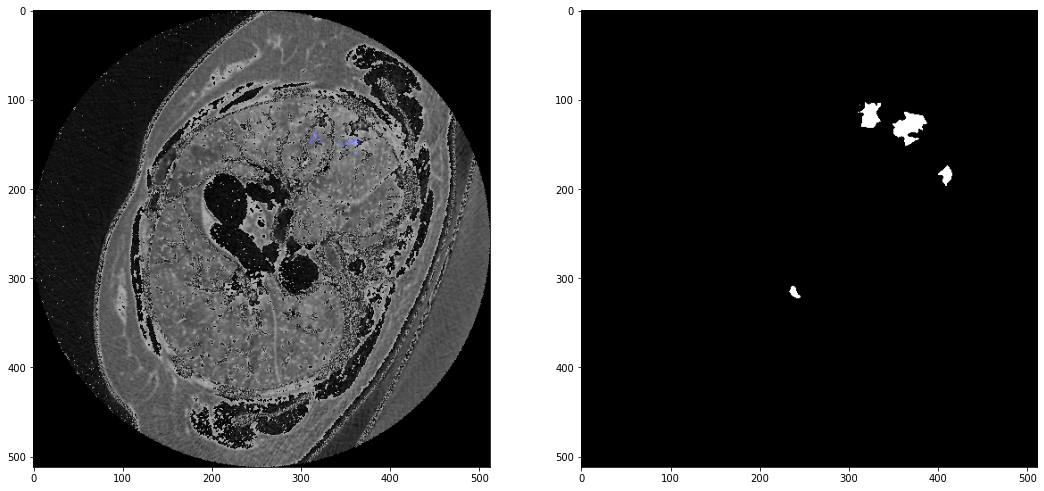

In [23]:
#Visualize some of the slices
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask): # Функция возвращает картинку с наложенной на неё маской - label, которые являются ковидной штукой
    print(image)
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.3
    )

slices_num = (100, )
slices = []
for idx in slices_num:
    k = valid_dataset[idx]
    slices.append(blend(
        k[0][0].numpy(),
        k[1][0].numpy()
    ))
    prediction = model.forward(k[0].view(1, 1, 512, 512).to(device)).cpu().detach().transpose(0, 1).transpose(1, 2).transpose(2, 3)[0]
    prediction[prediction >= 0.99] = 1
    prediction[prediction < 0.99] = 0
    slices.append(
        torch.cat([prediction, prediction, prediction], 2)
    )

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

### 5. Inference

Ниже код только для отправки решения на **Kaggle**

In [24]:
"""
Load testing data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
"""
with open(core_path + 'testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testing = []
label_testing = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path + "images/", entry['image'][:-3]))
    images_testing.append(image.get_fdata())

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() >= 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

In [26]:
thresh = 0.99
n_id = len(images_testing)

for i in range(n_id):
    n_imgs = images_testing[i][1].shape[-1]
    name = images_testing[i][0]
    
    for j in range(n_imgs):
        inp = images_testing[i][:, :, j]

        inp = torch.from_numpy(np.array(inp))
        inp = inp.to(device)
        inp = inp.type(torch.float)
        inp = inp.view(-1, 1, 512, 512)

        res = model(inp)
        res = res.cpu()
        outp = res.detach().numpy()[0][0]

        outp /= np.max(outp)
        outp[outp >= thresh] = 1
        outp[outp < thresh] = 0

        label_testing.append(outp)

In [27]:
import csv
with open(f'{core_path}testing_data.json', 'r') as f:
            dict_testing = json.load(f)

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, label_testing)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])

0it [00:00, ?it/s]